# Problem 1: $-u'' = e^{sin x}, u(0)=0, u(1)=0$

We'll derive an exact integral representation, implement a finite-difference solver, validate convergence, and study the accuracy limitation (truncation vs round-off).

Goals:
- Derive and implement an exact solution formula via Green's function.
- Implement a second-order finite difference method with a tridiagonal solver.
- Perform a convergence study and estimate observed order.
- Explore the accuracy floor and explain why error stops decreasing.

## integral form

For $-u''(x) = f(x)$ with $u(0)=u(1)=0$, the Green's function G(x,t) yields

$u(x) = ∫_0^1 G(x,t) f(t) dt$, where
$G(x,t) = { t(1-x), t ≤ x; x(1-t), t ≥ x }$.

With $f(t) = e^{sin t}$, an equivalent and very convenient form (from two integrations) is

$u(x) = - ∫_0^x (x - t) f(t) dt + x ∫_0^1 (1 - t) f(t) dt$.

This reduces evaluation to 1D integrals. We'll compute them with a composite uniform trapezoid rule (no external solvers).

In [56]:
# Exact solution implementation (using uniform trapezoid quadrature)
from math import sin, exp

# Composite uniform trapezoid rule
def trapezoid_uniform(f, a, b, n):
    if n <= 0:
        return 0.0
    h = (b - a) / float(n)
    s = 0.5*(f(a) + f(b))
    for k in range(1, n):
        s += f(a + k*h)
    return s*h

# Base quadrature density per unit interval for exact integrals
# Kept moderate to balance speed and accuracy when used repeatedly
n_per_unit = 4000

f = lambda t: exp(sin(t))

# Precompute I = ∫_0^1 (1-t) f(t) dt for reuse (uniform trapezoid)
I = trapezoid_uniform(lambda t: (1.0 - t)*f(t), 0.0, 1.0, int(n_per_unit*1))

def u_exact(x):
    # J(x) = ∫_0^x (x - t) f(t) dt = x∫_0^x f(t)dt - ∫_0^x t f(t) dt.
    nseg = max(1, int(max(x, 1e-12)*n_per_unit))
    int1 = trapezoid_uniform(lambda t: f(t), 0.0, x, nseg)
    int2 = trapezoid_uniform(lambda t: t*f(t), 0.0, x, nseg)
    J = x*int1 - int2
    return -J + x*I

# Quick sanity: endpoints
print('u_exact(0)=', u_exact(0.0))
print('u_exact(1)=', u_exact(1.0))

u_exact(0)= 0.0
u_exact(1)= -5.551115123125783e-16


In [57]:
# Finite difference method (2nd-order) with Thomas algorithm
from math import isfinite

def finite_difference_method(f, N):
    """
    Solve -u''=f on (0,1) with u(0)=u(1)=0 using central differences.
    Grid: x_i = i h, i=0..N, h=1/N. Unknowns are interior u_1..u_{N-1}.
    Tridiagonal system: (1/h^2) T u = f, where T has 2 on diagonal and -1 on off-diagonals.
    Returns: xs (N+1 nodes), us (N+1 values)
    """
    h = 1.0/float(N)
    n = N-1  # interior unknowns
    if n <= 0:
        return [0.0,1.0], [0.0,0.0]

    # Tridiagonal coefficients for interior system Au=d
    invh2 = 1.0/(h*h)
    a = [-invh2]*(n-1)       # subdiag
    b = [ 2.0*invh2]*n       # diag
    c = [-invh2]*(n-1)       # superdiag
    d = [ f((i+1)*h) for i in range(n) ]  # RHS at interior nodes

    # Thomas forward elimination
    for i in range(1, n):
        m = a[i-1] / b[i-1]
        b[i] = b[i] - m*c[i-1]
        d[i] = d[i] - m*d[i-1]

    # Back substitution
    u_int = [0.0]*n
    u_int[-1] = d[-1] / b[-1]
    for i in range(n-2, -1, -1):
        u_int[i] = (d[i] - c[i]*u_int[i+1]) / b[i]

    xs = [i*h for i in range(N+1)]
    us = [0.0] + u_int + [0.0]
    return xs, us

# Small smoke test
xs, us = finite_difference_method(lambda x: exp(sin(x)), 20)
print('FD solver ran: len(xs)=', len(xs), 'u(0)=', us[0], 'u(1)=', us[-1])

FD solver ran: len(xs)= 21 u(0)= 0.0 u(1)= 0.0


N=   20, h= 5.000e-02, max_err= 1.103e-05, solve+eval time=  0.01s
N=   40, h= 2.500e-02, max_err= 2.756e-06, solve+eval time=  0.02s
N=   80, h= 1.250e-02, max_err= 6.885e-07, solve+eval time=  0.04s
N=  160, h= 6.250e-03, max_err= 1.719e-07, solve+eval time=  0.07s
N=  320, h= 3.125e-03, max_err= 4.278e-08, solve+eval time=  0.15s
N=  320, h= 3.125e-03, max_err= 4.278e-08, solve+eval time=  0.15s
N=  640, h= 1.563e-03, max_err= 1.049e-08, solve+eval time=  0.30s
N=  640, h= 1.563e-03, max_err= 1.049e-08, solve+eval time=  0.30s
N= 1280, h= 7.813e-04, max_err= 2.420e-09, solve+eval time=  0.60s
N= 1280, h= 7.813e-04, max_err= 2.420e-09, solve+eval time=  0.60s
N= 2560, h= 3.906e-04, max_err= 4.023e-10, solve+eval time=  1.19s
N= 2560, h= 3.906e-04, max_err= 4.023e-10, solve+eval time=  1.19s


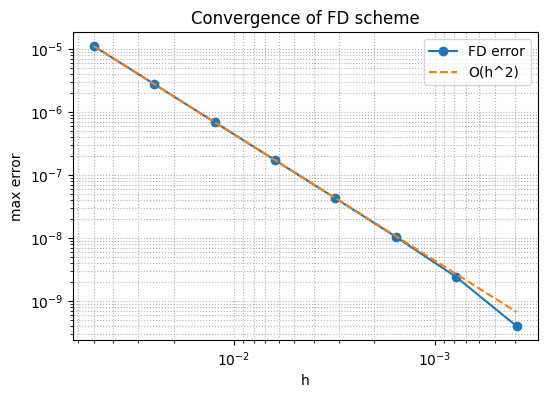

In [58]:
# Convergence study and observed order
import time
import math

Ns = [20, 40, 80, 160, 320, 640, 1280, 2560]
errs = []
hs = []
start_all = time.time()
for N in Ns:
    t0 = time.time()
    xs, us = finite_difference_method(f, N)
    e = max_error(xs, us)
    dt = time.time() - t0
    errs.append(e)
    hs.append(1.0/N)
    print(f"N={N:5d}, h={1.0/N:10.3e}, max_err={e:10.3e}, solve+eval time={dt:6.2f}s")

# Optional plotting if matplotlib is available
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    plt.loglog(hs, errs, 'o-', label='FD error')
    # Reference h^2 line anchored at first point
    c_ref = errs[0]/(hs[0]**2)
    plt.loglog(hs, [c_ref*(h**2) for h in hs], '--', label='O(h^2)')
    plt.gca().invert_xaxis()
    plt.xlabel('h')
    plt.ylabel('max error')
    plt.legend()
    plt.title('Convergence of FD scheme')
    plt.grid(True, which='both', ls=':')
    plt.show()
except Exception as e:
    print('(Plot skipped - matplotlib not available)')

In [59]:
# Accuracy floor exploration: truncate vs round-off
import math

# Model: E(h) ≈ C h^2 + D * eps / h^2, eps ~ machine epsilon (~2.22e-16)
# We'll gather data for growing N until error stops decreasing or time too large.

max_N = 200000  # upper cap to avoid extreme runtime
results = []
C_est = None
D_est = None
epsilon = 2.22e-16

# We'll sample N logarithmically
import numpy as np
N_values = np.unique(np.round(np.logspace(2, 5.2, 28)).astype(int))  # from ~1e2 to ~1.6e5

for N in N_values:
    if N > max_N: break
    xs, us = finite_difference_method(f, N)
    e = max_error(xs, us)
    h = 1.0/N
    results.append((N, h, e))
    print(f"floor sweep N={N:7d}, h={h:.3e}, err={e:.3e}")

# Find minimum error and corresponding N
min_entry = min(results, key=lambda r: r[2])
print(f"\nMinimum observed error ~ {min_entry[2]:.3e} at N={min_entry[0]} (h={min_entry[1]:.3e})")

# Rough fit of C and D using early and late regime points
# Use first few points for truncation-dominated to estimate C
early = [r for r in results if r[0] <= 640]
if early:
    # Fit C by averaging e/h^2
    C_vals = [r[2]/(r[1]**2) for r in early]
    C_est = sum(C_vals)/len(C_vals)
# Use large-N tail for round-off dominated to estimate D
late = [r for r in results if r[0] >= 40000]
if late:
    # For round-off dominated: e ≈ D*eps/h^2 => D ≈ e*h^2/eps
    D_vals = [r[2]*(r[1]**2)/epsilon for r in late]
    D_est = sum(D_vals)/len(D_vals)
print(f"Estimated C ≈ {C_est:.3e} (from early regime)" if C_est else 'C not estimated')
print(f"Estimated D ≈ {D_est:.3e} (from late regime)" if D_est else 'D not estimated')

if C_est and D_est:
    # Optimal h from derivative: d/dh (C h^2 + D eps / h^2)=0 => h_opt = (D eps / C)**0.25
    h_opt = (D_est * epsilon / C_est)**0.25
    print(f"Predicted optimal h ≈ {h_opt:.3e}, predicted minimal error ≈ {C_est*h_opt**2 + D_est*epsilon/h_opt**2:.3e}")

# Compare predicted with observed


floor sweep N=    100, h=1.000e-02, err=4.406e-07
floor sweep N=    131, h=7.634e-03, err=2.566e-07
floor sweep N=    173, h=5.780e-03, err=1.470e-07
floor sweep N=    227, h=4.405e-03, err=8.529e-08
floor sweep N=    173, h=5.780e-03, err=1.470e-07
floor sweep N=    227, h=4.405e-03, err=8.529e-08
floor sweep N=    298, h=3.356e-03, err=4.938e-08
floor sweep N=    391, h=2.558e-03, err=2.857e-08
floor sweep N=    298, h=3.356e-03, err=4.938e-08
floor sweep N=    391, h=2.558e-03, err=2.857e-08
floor sweep N=    514, h=1.946e-03, err=1.642e-08
floor sweep N=    514, h=1.946e-03, err=1.642e-08
floor sweep N=    676, h=1.479e-03, err=9.377e-09
floor sweep N=    676, h=1.479e-03, err=9.377e-09
floor sweep N=    887, h=1.127e-03, err=5.333e-09
floor sweep N=    887, h=1.127e-03, err=5.333e-09
floor sweep N=   1166, h=8.576e-04, err=2.973e-09
floor sweep N=   1166, h=8.576e-04, err=2.973e-09
floor sweep N=   1532, h=6.527e-04, err=1.608e-09
floor sweep N=   1532, h=6.527e-04, err=1.608e-09


## Problem 2 : 

Consider the boundary value problem

$- u''(x) = sin(x)$,    with  $u(0) = 1,  u(1) = 1$.

This problem admits a closed-form solution by integrating twice:

$u'' = -(sin x )  =>  u' = cos x + C_1  =>  u(x) = sin x  + C_1 x + C_2$.

Enforcing $u(0)=1$ gives $C_2=1$; enforcing $u(1)=1$ gives $C_1 = -sin(1)$.
Thus the exact solution is

$u_{exact2}(x) = sin(x) - sin(1) x + 1$.

We'll solve this problem using the same second-order finite difference method and Thomas tridiagonal solver as in Problem 1. Since $u(0)=u(1)=1$, we solve for $v = u - 1$, which satisfies $v(0)=v(1)=0$ and -v'' = sin(x), then reconstruct u = v + 1 and compare with the exact solution.

Problem 2: N=200, h=5.000e-03, max error=1.250e-07


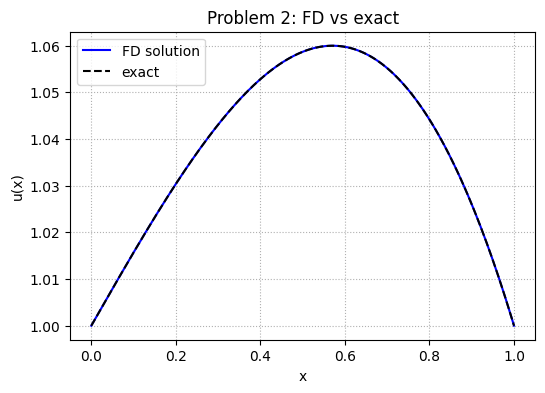

In [60]:
# Problem 2: FD solution and comparison with exact
import math

def u_exact2(x):
    return math.sin(x) - (math.sin(1.0))*x + 1.0

# Solve for v with zero BCs using the existing FD solver, then u = v + 1
N = 200
f2 = lambda x: math.sin(x)
xs2, v2 = finite_difference_method(f2, N)
u2 = [vi + 1.0 for vi in v2]

# Max-norm error vs exact
err2 = max(abs(u2[i] - u_exact2(xs2[i])) for i in range(len(xs2)))
print(f"Problem 2: N={N}, h={1.0/N:.3e}, max error={err2:.3e}")

# Optional quick plot
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    plt.plot(xs2, u2, 'b-', label='FD solution')
    xs_dense = [i/1000 for i in range(1001)]
    plt.plot(xs_dense, [u_exact2(x) for x in xs_dense], 'k--', label='exact')
    plt.xlabel('x'); plt.ylabel('u(x)'); plt.title('Problem 2: FD vs exact')
    plt.legend(); plt.grid(True, ls=':'); plt.show()
except Exception:
    pass

N=   20, h= 5.000e-02, max_err= 1.248e-05
N=   40, h= 2.500e-02, max_err= 3.125e-06
N=   80, h= 1.250e-02, max_err= 7.811e-07
N=  160, h= 6.250e-03, max_err= 1.953e-07
N=  320, h= 3.125e-03, max_err= 4.882e-08
N=  640, h= 1.563e-03, max_err= 1.221e-08
N= 1280, h= 7.813e-04, max_err= 3.051e-09
N= 3000, h= 3.333e-04, max_err= 5.555e-10


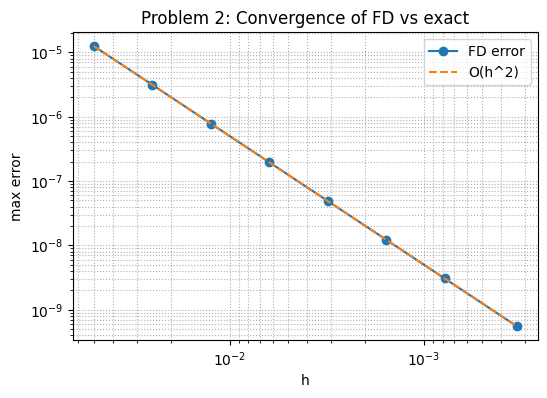

In [61]:
# Problem 2: Convergence study vs exact solution
import time, math

Ns = [20, 40, 80, 160, 320, 640, 1280,3000]
errs = []
hs = []
for N in Ns:
    f2 = lambda x: math.sin(x)
    xs, v = finite_difference_method(f2, N)
    u = [vi + 1.0 for vi in v]
    e = max(abs(u[i] - u_exact2(xs[i])) for i in range(len(xs)))
    errs.append(e)
    hs.append(1.0/N)
    print(f"N={N:5d}, h={1.0/N:10.3e}, max_err={e:10.3e}")

try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    plt.loglog(hs, errs, 'o-', label='FD error')
    c_ref = errs[0]/(hs[0]**2)
    plt.loglog(hs, [c_ref*(h**2) for h in hs], '--', label='O(h^2)')
    plt.gca().invert_xaxis()
    plt.xlabel('h'); plt.ylabel('max error'); plt.title('Problem 2: Convergence of FD vs exact')
    plt.legend(); plt.grid(True, which='both', ls=':'); plt.show()
except Exception:
    pass